# Assignment 4: Emotion Classification using LLMs

Let us start off with our installations and imports.

In [ ]:
%pip install datasets
%pip install transformers

In [ ]:
import evaluate
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from xgboost import XGBClassifier

%matplotlib inline
plt.rc('axes', axisbelow=True)
plt.style.use(['seaborn-v0_8', 'seaborn-v0_8-whitegrid'])

## Task 1: Preprocess dataset
Let us first load our data set and explore it a bit.

In [5]:
ds = load_dataset("google-research-datasets/go_emotions", "simplified")
ds = ds.filter(lambda x: len(x['labels']) == 1).map(lambda x: {'text': x['text'], 'label': x['labels'][0]}, remove_columns=['labels', 'id'])

EMOTION_MAP = {
  0: 'Admiration',
  1: 'Amusement',
  2: 'Anger',
  3: 'Annoyance',
  4: 'Approval',
  5: 'Caring',
  6: 'Confusion',
  7: 'Curiosity',
  8: 'Desire',
  9: 'Disappointment',
  10: 'Disapproval',
  11: 'Disgust',
  12: 'Embarrassment',
  13: 'Excitement',
  14: 'Fear',
  15: 'Gratitude',
  16: 'Grief',
  17: 'Joy',
  18: 'Love',
  19: 'Nervousness',
  20: 'Optimism',
  21: 'Pride',
  22: 'Realization',
  23: 'Relief',
  24: 'Remorse',
  25: 'Sadness',
  26: 'Surprise',
  27: 'Neutral'
}

NUM_CLASSES = len(EMOTION_MAP)

Let us look at the class distribution of the comment emotions.

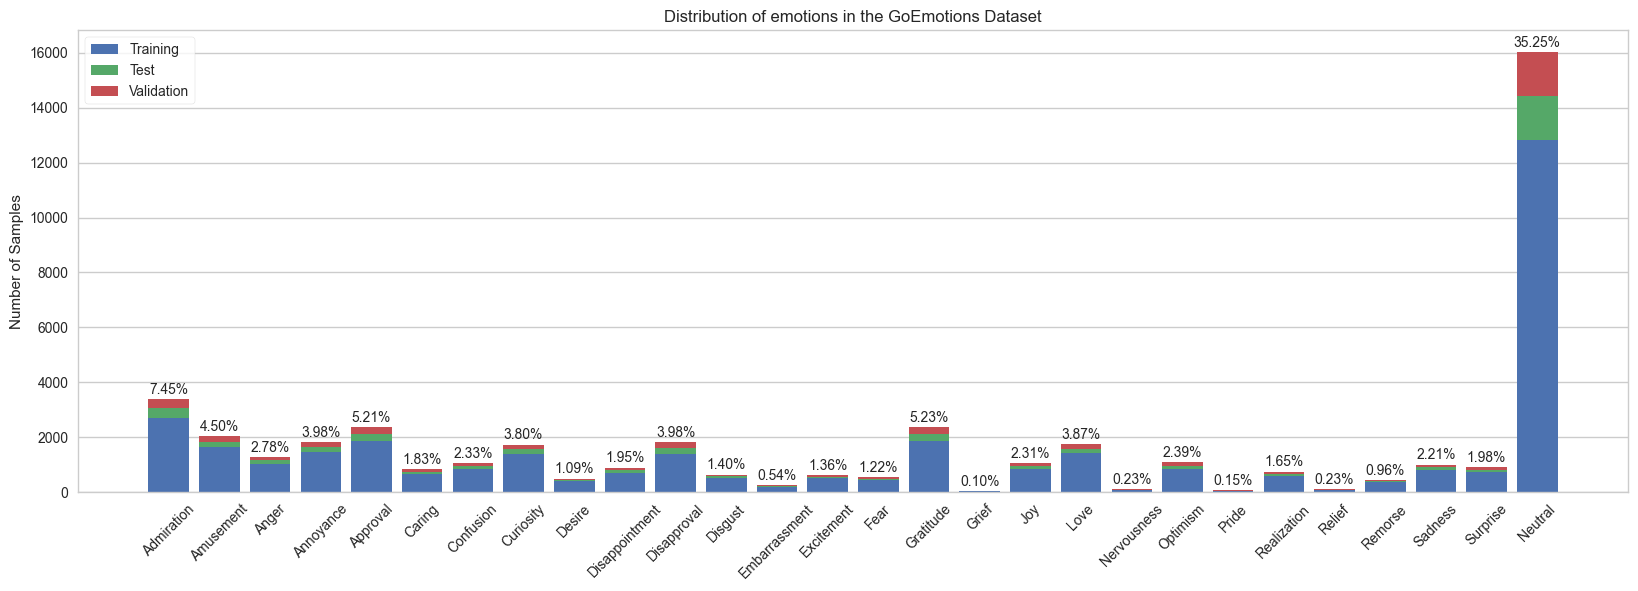

In [9]:
TRAIN_DIST = np.unique(ds['train']['label'], return_counts=True)[1]
TEST_DIST = np.unique(ds['test']['label'], return_counts=True)[1]
VAL_DIST = np.unique(ds['validation']['label'], return_counts=True)[1]

plt.figure(figsize=(20, 6))
plt.xticks(range(NUM_CLASSES), EMOTION_MAP.values(), rotation=45)

bottom = np.zeros(NUM_CLASSES)

for label, distribution in [("Training", TRAIN_DIST), ("Test", TEST_DIST), ("Validation", VAL_DIST)]:
  plt.bar(range(NUM_CLASSES), distribution, bottom=bottom, label=label)
  bottom += distribution

for i in range(NUM_CLASSES):
  plt.text(i, bottom[i] + 600, f"{bottom[i] / (len(ds['train']) + len(ds['test']) + len(ds['validation'])):.2%}", ha='center', va='top')

plt.title("Distribution of emotions in the GoEmotions Dataset")
plt.ylabel("Number of Samples")
plt.grid(axis='x')
plt.legend(frameon=True)
plt.savefig("1a.png", dpi=600, bbox_inches='tight')

Wow! A very high proportion of neutral comments. Generally, based on the number of labels, the remaining categories seem decently distributed. Let us take a look also at the distribution of text lengths in the training dataset.

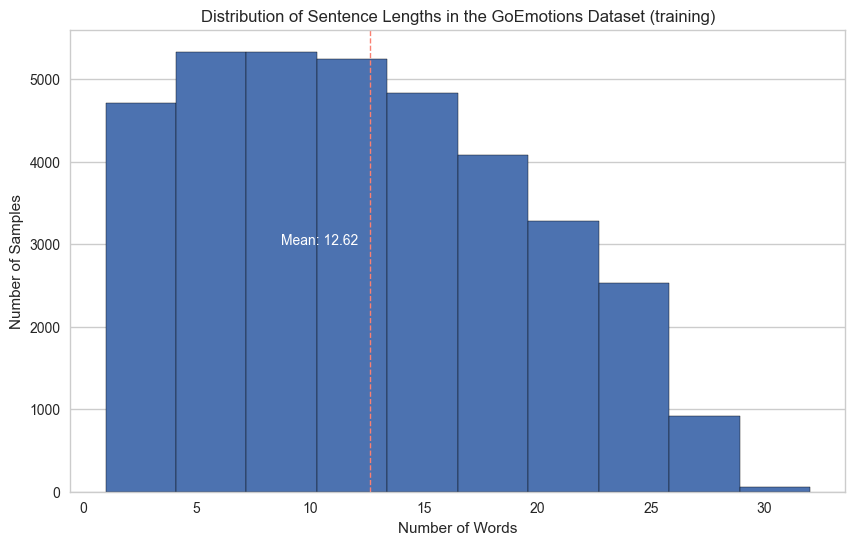

In [10]:
lengths = np.array([len(x.split()) for x in ds['train']['text']])

plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=10, edgecolor='black')
plt.axvline(np.mean(lengths), color='salmon', linestyle='dashed', linewidth=1)
plt.text(np.mean(lengths) - 0.5, 3000, f"Mean: {np.mean(lengths):.2f}", color='white', ha='right')
plt.title("Distribution of Sentence Lengths in the GoEmotions Dataset (training)")
plt.xlabel("Number of Words")
plt.ylabel("Number of Samples")
plt.grid(axis='x')
plt.savefig("1b.png", dpi=600, bbox_inches='tight')

Seems that our comments are towards the shorter end, with about 13 words on average. Now, let us pre-process our datasets, starting with our bag-of-words representation for our Naive Bayes classifier. Of course, we will only fit on the train dataset to avoid data leakage.

In [6]:
train = ds['train']
test = ds['test']
val = ds['validation']

In [14]:
v = CountVectorizer()

x_train_nb, y_train_nb = v.fit_transform(train['text']), np.array(train['label'])
x_test_nb, y_test_nb = v.transform(test['text']), np.array(test['label'])
x_val_nb, y_val_nb = v.transform(val['text']), np.array(val['label'])

Now, we can also prepare our data for our random forest classifier. We will use both a count vectorizer and a tf-idf vectorizer to see if there are any differences when using the two methods.

In [19]:
t = TfidfVectorizer()
c = CountVectorizer()

x_train_t, y_train_t = t.fit_transform(train['text']), np.array(train['label'])
x_test_t, y_test_t = t.transform(test['text']), np.array(test['label'])

x_train_c, y_train_c = c.fit_transform(train['text']), np.array(train['label'])
x_test_c, y_test_c = c.transform(test['text']), np.array(test['label'])

Finally, let us tokenize our data for our LLM.

In [76]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
tokenize = lambda x: tokenizer(x['text'], truncation=True, padding='max_length', max_length=128)

tokenized_ds = ds.map(tokenize, batched=True)

tokenized_train = tokenized_ds['train']
tokenized_test = tokenized_ds['test']
tokenized_val = tokenized_ds['validation']

Map:   0%|          | 0/4548 [00:00<?, ? examples/s]

## Task 2: Implement Naive Bayes and Finetune an LLM
We will utilize the default settings for our random forest classifier, meaning 100 trees in the forest and a gini criterion.

### 2.1 Naive Bayes Model

We will implement our Naive Bayes classifier as follows. We will add a single parameter for Bayesian smoothing (i.e., $\alpha=\beta$) which we can treat as a hyper-parameter and tune over.

In [8]:
class BayesianClassifier:
  def __init__(self, alpha=1):
    self.alpha = alpha  # For Bayesian smoothing

  def logsumexp(self, x):
    z = np.max(x, axis=1, keepdims=True)
    return z + np.log(np.sum(np.exp(x - z), axis=1, keepdims=True))

  def fit(self, x, y):
    N, D = x.shape
    C = NUM_CLASSES

    theta = np.zeros((C, D))
    Nc = np.zeros(C)

    for c in range(C):
      xc = x[y == c]
      Nc[c] = xc.shape[0]

      theta[c] = (xc.sum(axis=0) + self.alpha) / (np.sum(xc) + self.alpha * D)

    self.theta = theta
    self.pi = (Nc + self.alpha) / (N + self.alpha * C)

  def predict(self, x):
    lpo = np.log(self.pi) + x @ np.log(self.theta.T)
    return np.exp(lpo - self.logsumexp(lpo))

  def evaluate(self, y, yh):
    return np.mean(np.argmax(yh, axis=1) == y)

  def evaluate_by_class(self, y, yh):
    pred = np.argmax(yh, axis=1)
    return np.array([np.mean(pred[y == c] == c) for c in range(NUM_CLASSES)])


### 2.2 BERT LLM
We will define a wrapper class to simplify interactions with our BERT model.

In [72]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.mps.is_available() else 'cpu')

class BERTWrapper:
  def __init__(self, epochs: int = 5, alpha: float = 5e-5, b: int = 32):
    self.model = AutoModelForSequenceClassification.from_pretrained(
      "google-bert/bert-base-uncased",
      num_labels=NUM_CLASSES,
      output_attentions=True
    )
    self.device = device
    self.epochs = epochs
    self.alpha = alpha
    self.b = b

  def fit(self, dataset):
    self.model.train()
    self.model.to(self.device)

    training_args = TrainingArguments(
      output_dir="results",
      num_train_epochs=self.epochs,
      per_device_train_batch_size=self.b,
      per_device_eval_batch_size=self.b,
    )

    trainer = Trainer(
      model=self.model,
      args=training_args,
      train_dataset=dataset,
    )

    self.model.to('cpu')
    torch.mps.empty_cache()
    return trainer.train()

  def get_loader(self, dataset):
    dataset = dataset.remove_columns(['text']).rename_column('label', 'labels')
    dataset.set_format('torch')
    return DataLoader(dataset, batch_size=16)

  def predict(self, dataset):
    self.model.to(self.device)
    loader = self.get_loader(dataset)
    self.model.eval()
    yh = []

    with torch.no_grad():
      for batch in tqdm(loader):
        inputs = {k: v.to(self.device) for k, v in batch.items()}
        outputs = self.model(**inputs)
        yh.append(outputs.logits.cpu().numpy())

    self.model.to('cpu')
    torch.mps.empty_cache()
    return np.concatenate(yh)

  def get_attention_head(self, tokenized_text, layer, head):
    return self.model(**tokenized_text).attentions[0][layer][head].detach().cpu().numpy()

  def evaluate(self, y, yh):
    metric = evaluate.load('accuracy')
    pred = np.argmax(yh, axis=1)
    return metric.compute(predictions=pred, references=y)

  def evaluate_f1(self, y, yh):
    metric = evaluate.load('f1')
    pred = np.argmax(yh, axis=1)
    return metric.compute(predictions=pred, references=y, average='macro')

  def evaluate_by_class(self, y, yh):
    y = np.array(y)
    pred = np.argmax(yh, axis=1)
    return np.array([np.mean(pred[y == c] == c) for c in range(NUM_CLASSES)])

## Task 3: Run experiments
Let us see how each of our models fare, starting with Naive Bayes. We will tune to find the optimal smoothing factor using our validation set.

/var/folders/j9/t7lmvw5n2knf_2684z7x78ph0000gn/T/ipykernel_1181/244780782.py:26: RuntimeWarning: divide by zero encountered in log
  lpo = np.log(self.pi) + x @ np.log(self.theta.T)
/var/folders/j9/t7lmvw5n2knf_2684z7x78ph0000gn/T/ipykernel_1181/244780782.py:7: RuntimeWarning: invalid value encountered in subtract
  return z + np.log(np.sum(np.exp(x - z), axis=1, keepdims=True))


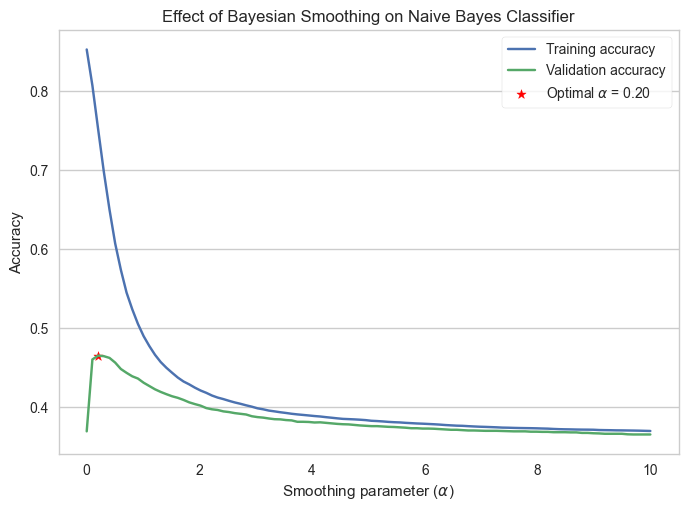

In [15]:
alpha = np.linspace(0, 10, 100)

train_acc = []
val_acc = []

for a in alpha:
  model = BayesianClassifier(alpha=a)
  model.fit(x_train_nb, y_train_nb)

  y_train_pred = model.predict(x_train_nb)
  y_val_pred = model.predict(x_val_nb)

  train_acc.append(model.evaluate(y_train_nb, y_train_pred))
  val_acc.append(model.evaluate(y_val_nb, y_val_pred))


opt = alpha[np.argmax(val_acc)]

plt.plot(alpha, train_acc, label="Training accuracy")
plt.plot(alpha, val_acc, label="Validation accuracy")
plt.scatter(opt, max(val_acc), color='red', marker='*', label=f"Optimal $\\alpha$ = {opt:.2f}")
plt.xlabel("Smoothing parameter ($\\alpha$)")
plt.ylabel("Accuracy")
plt.title("Effect of Bayesian Smoothing on Naive Bayes Classifier")
plt.legend(frameon=True)
plt.grid(axis='x')
plt.savefig("3.1a.png", dpi=600, bbox_inches='tight')

Very interesting, we see that there is a general decreasing trend with respect to the training accuracy as our smoothing parameter rises. The curve for our validation set is also interesting, as it start very low, quickly rises to maximal performance, and then fades out similar to the training accuracy. With this, let us evaluate the Naive Bayes model on our train and test sets.

In [16]:
model = BayesianClassifier(alpha=opt)
model.fit(x_train_nb, y_train_nb)

y_train_pred = model.predict(x_train_nb)
y_test_pred = model.predict(x_test_nb)

print(model.evaluate(y_train_nb, y_train_pred))
print(model.evaluate(y_test_nb, y_test_pred))
print(model.evaluate_by_class(y_test_nb, y_test_pred))

0.7523410818552385
0.46339869281045754
[0.56034483 0.45698925 0.09923664 0.12371134 0.15254237 0.15116279
 0.04123711 0.14772727 0.05357143 0.05681818 0.07692308 0.18421053
 0.         0.10526316 0.06153846 0.80769231 0.         0.2688172
 0.49375    0.         0.34579439 0.         0.04494382 0.
 0.15909091 0.24509804 0.06896552 0.80386052]


We can see the effect of the over-representation of the neutral class. Otherwise, we see that the performance of the test set is similar to the validation set.

Let us now look at the performance of our baseline random forest.

In [63]:
rft = RandomForestClassifier(n_jobs=-1)
rfc = RandomForestClassifier(n_jobs=-1)

rft.fit(x_train_t, y_train_t)
rfc.fit(x_train_c, y_train_c)

print(rft.score(x_train_t, y_train_t), rft.score(x_test_t, y_test_t))
print(rfc.score(x_train_c, y_train_c), rfc.score(x_test_c, y_test_c))

0.9961165583342514 0.5429193899782135
0.9961441004737248 0.5424836601307189


In [ ]:
rft_pred = rft.predict(x_test_t)
rfc_pred = rfc.predict(x_test_c)

rft_cm = confusion_matrix(y_test_t, rft_pred)
rfc_cm = confusion_matrix(y_test_c, rfc_pred)

print(rft_cm.diagonal() / rft_cm.sum(axis=1))
print(rfc_cm.diagonal() / rfc_cm.sum(axis=1))

[0.54310345 0.68817204 0.19847328 0.03608247 0.09745763 0.10465116
 0.06185567 0.03977273 0.16071429 0.01136364 0.02564103 0.30263158
 0.04347826 0.21052632 0.32307692 0.86923077 0.         0.38709677
 0.8125     0.         0.51401869 0.         0.03370787 0.
 0.56818182 0.34313725 0.2183908  0.93150685]
[0.53448276 0.69354839 0.2519084  0.03092784 0.1059322  0.10465116
 0.02061856 0.05113636 0.19642857 0.         0.05128205 0.31578947
 0.         0.29824561 0.33846154 0.87692308 0.         0.39784946
 0.8        0.         0.51401869 0.         0.02247191 0.
 0.63636364 0.35294118 0.16091954 0.92092154]


We see there is a noticeable increase in the performance as compared to our Naive Bayes classifier! It seems the two vectorization methods (td-idf vs count) have little effect on the result. We also note that the trend in class accuracies are similar to what we observed with our Naive Bayes classifier (i.e., over-represented classes have higher accuracies).

Let us now see how our BERT model performs, starting with the pre-trained model without fine-tuning.

In [52]:
model = BERTWrapper(epochs=3)
outputs = model.predict(tokenized_test)
test_acc = model.evaluate(tokenized_test['label'], outputs)
test_f1 = model.evaluate_f1(tokenized_test['label'], outputs)
test_class_accs = model.evaluate_by_class(tokenized_test['label'], outputs)

print(f"Test accuracy: {test_acc['accuracy']:.2%}")
print(f"Test F1: {test_f1['f1']:.4}")
print(test_class_accs)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/287 [00:00<?, ?it/s]

Test accuracy: 1.59%
Test F1: 0.003139
[0.         0.02688172 0.         0.         0.         0.76744186
 0.         0.         0.         0.         0.         0.
 0.         0.01754386 0.         0.         0.         0.
 0.         0.         0.         0.14285714 0.         0.
 0.         0.         0.         0.        ]


Wow, very poor performance. But, this makes sense as the model has no idea about our classification task and seems to just favour an arbitrary class ("caring", in this case). Let us now fine-tune the model. We will train on a limited sample (1/3 of the original training set) due to time and memory limitation.

In [92]:
model = BERTWrapper(epochs=5, b=8)
small_train = tokenized_train.shuffle().select(range(10000))

model.fit(small_train)
outputs = model.predict(tokenized_test)
test_acc = model.evaluate(tokenized_test['label'], outputs)
test_f1 = model.evaluate_f1(tokenized_test['label'], outputs)
test_class_accs = model.evaluate_by_class(tokenized_test['label'], outputs)

print(f"Test accuracy: {test_acc['accuracy']:.2%}")
print(f"Test F1: {test_f1['f1']:.4}")
print(test_class_accs)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/6250 [00:00<?, ?it/s]

{'loss': 2.0829, 'grad_norm': 10.43814468383789, 'learning_rate': 4.600000000000001e-05, 'epoch': 0.4}
{'loss': 1.6667, 'grad_norm': 14.92647933959961, 'learning_rate': 4.2e-05, 'epoch': 0.8}
{'loss': 1.4109, 'grad_norm': 20.697900772094727, 'learning_rate': 3.8e-05, 'epoch': 1.2}
{'loss': 1.1968, 'grad_norm': 21.33138656616211, 'learning_rate': 3.4000000000000007e-05, 'epoch': 1.6}
{'loss': 1.1849, 'grad_norm': 19.533933639526367, 'learning_rate': 3e-05, 'epoch': 2.0}
{'loss': 0.7473, 'grad_norm': 10.858421325683594, 'learning_rate': 2.6000000000000002e-05, 'epoch': 2.4}
{'loss': 0.7919, 'grad_norm': 8.332032203674316, 'learning_rate': 2.2000000000000003e-05, 'epoch': 2.8}
{'loss': 0.6051, 'grad_norm': 18.196941375732422, 'learning_rate': 1.8e-05, 'epoch': 3.2}
{'loss': 0.4065, 'grad_norm': 20.26436996459961, 'learning_rate': 1.4000000000000001e-05, 'epoch': 3.6}
{'loss': 0.4008, 'grad_norm': 11.804186820983887, 'learning_rate': 1e-05, 'epoch': 4.0}
{'loss': 0.2144, 'grad_norm': 1.079

  0%|          | 0/287 [00:00<?, ?it/s]

Test accuracy: 58.74%
Test F1: 0.4516
[0.66666667 0.86021505 0.40458015 0.27835052 0.31355932 0.31395349
 0.43298969 0.52840909 0.5        0.23863636 0.36410256 0.46052632
 0.56521739 0.45614035 0.70769231 0.88846154 0.         0.55913978
 0.85       0.         0.55140187 0.         0.19101124 0.14285714
 0.65909091 0.52941176 0.49425287 0.68430884]


We see a slight improvement in performance over our Random Forest classifier (4%). There are a few classes that have 0 accuracy, and if we cross-check their distributions, we see they are the ones that are very highly under-represented (< 0.25%). It may have been the case that our random sample of training data did not even include those cases, leading to their poor performance. Otherwise, we see that the effect of class distribution is not as noticeable with this model, i.e., the performance on the neutral comments does not significantly outperform majority of the performances of other classes.

Now, let us examine the first attention head of the first layer for a correct and an incorrect example.

In [234]:
preds = np.argmax(outputs, axis=1)
correct = [(e['text'], e['label']) for e, p in zip(tokenized_test, preds) if e['label'] == p and len(e['text'].split()) < 15]
incorrect = [(e['text'], e['label'], p) for e, p in zip(tokenized_test, preds) if e['label'] != p and len(e['text'].split()) < 15]

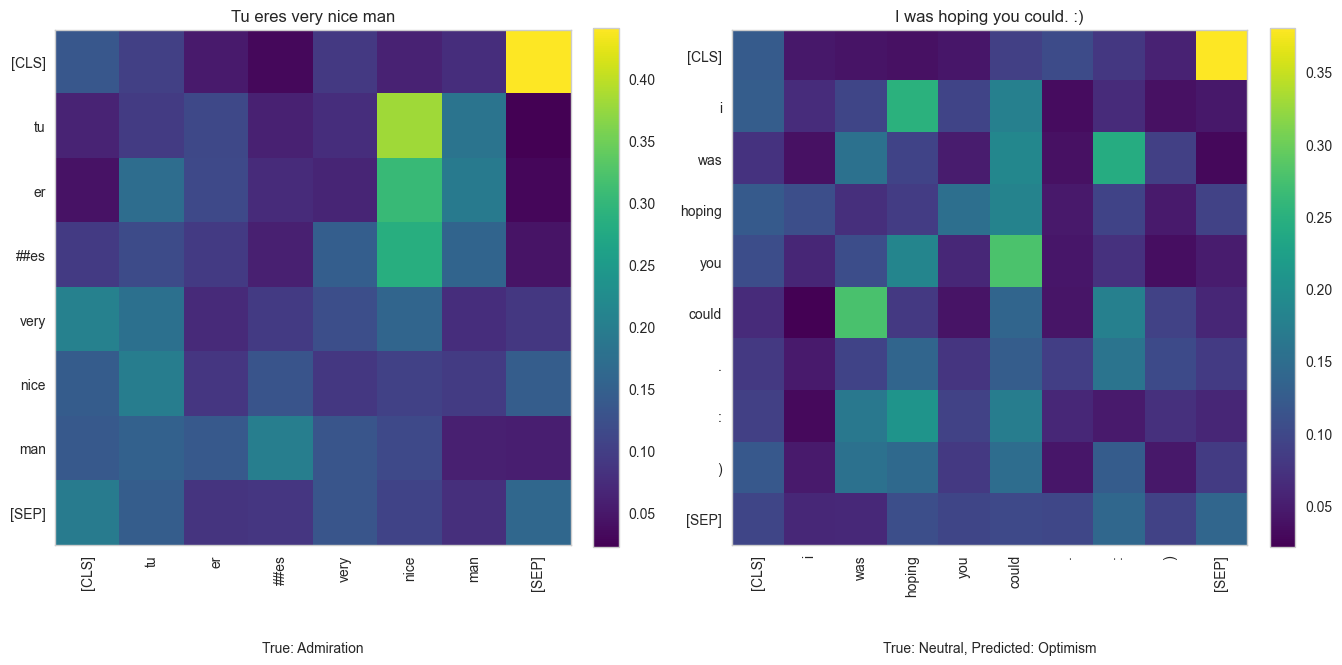

In [317]:
correct_sample, incorrect_sample = random.choice(correct), random.choice(incorrect)

tokenized_correct, tokenized_incorrect = tokenizer(correct_sample[0], truncation=True, padding='max_length', max_length=128, return_tensors='pt'), tokenizer(incorrect_sample[0], truncation=True, padding='max_length', max_length=128, return_tensors='pt')

ac = BERTWrapper.get_attention_head(model, tokenized_correct, 0, 0)
ai = BERTWrapper.get_attention_head(model, tokenized_incorrect, 0, 0)

tokenized_correct, tokenized_incorrect = tokenizer(correct_sample[0], truncation=True), tokenizer(incorrect_sample[0], truncation=True)

ctokens = tokenizer.convert_ids_to_tokens(tokenized_correct['input_ids'])
itokens = tokenizer.convert_ids_to_tokens(tokenized_incorrect['input_ids'])

ac = ac[:len(ctokens), :len(ctokens)]
ai = ai[:len(itokens), :len(itokens)]

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

for ax, tokens, att, ex in zip(axes, [ctokens, itokens], [ac, ai], [correct_sample, incorrect_sample]):
  im = ax.imshow(att, cmap='viridis', interpolation='nearest')
  ax.set_xticks(range(len(tokens)))
  ax.set_xticklabels(tokens, rotation=90)
  ax.set_yticks(range(len(tokens)))
  ax.set_yticklabels(tokens)
  ax.grid(False)
  ax.set_title(ex[0], loc='center', wrap=True)

  if len(ex) == 2:
    ax.text(0.5, -0.2, f"True: {EMOTION_MAP[ex[1]]}", ha='center', va='center', transform=ax.transAxes)
  else:
    ax.text(0.5, -0.2, f"True: {EMOTION_MAP[ex[1]]}, Predicted: {EMOTION_MAP[ex[2]]}", ha='center', va='center', transform=ax.transAxes)

  plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.savefig("3.2.png", dpi=600, bbox_inches='tight')


For our correct example (right), we see that the Spanish "tu eres"  and the word "nice" have high attention (i.e., you + are + nice), and we note that these words individually are sufficient to discern admiration. Interestingly, for our incorrect example, we note that the sentence hase been labeled with neutral while our model labels it as optimism. In fact, it seems that the true label may be incorrect! This might be attributed to the linguistic biases of the coders for this dataset. We note that the columns for "was", "hoping", and "could" indicate the highest attention.

## 4: Originality/Creativity
### 4.1 Investigating other baseline models

Let us see how the other baseline models perform on the dataset. Let us take a look at the softmax approach first.

In [25]:
lrt = LogisticRegression(max_iter=10 ** 6)
lrc = LogisticRegression(max_iter=10 ** 6)

lrt.fit(x_train_t, y_train_t)
lrc.fit(x_train_c, y_train_c)

print(lrt.score(x_train_t, y_train_t), lrt.score(x_test_t, y_test_t))
print(lrc.score(x_train_c, y_train_c), lrc.score(x_test_c, y_test_c))

0.6067257904594029 0.5490196078431373
0.8047813154125812 0.5562091503267974


We notice that the test performance is nearly identical to the random forest classifier. However, the training performance is much lower.

Now, let us examine the performance of XGBoost.

In [20]:
xgbt = XGBClassifier(n_jobs=-1)
xgbc = XGBClassifier(n_jobs=-1)

xgbt.fit(x_train_t, y_train_t)
xgbc.fit(x_train_c, y_train_c)

print(xgbt.score(x_train_t, y_train_t), xgbt.score(x_test_t, y_test_t))
print(xgbc.score(x_train_c, y_train_c), xgbc.score(x_test_c, y_test_c))

0.7232014982923873 0.5701525054466231
0.6844772501927949 0.5760348583877996


Here, we observe the highest test performance! As with softmax regression, we note that the training performance is much lower than what is experienced with the random forest classifier. This may indicate that the random forest classifier is overfitting to the training set.

### 4.2 Sophisticated vectorization

Let us use stopwords and minimum document frequency scores to see how it influences the performance of our baseline models and our Naive Bayes classifier.

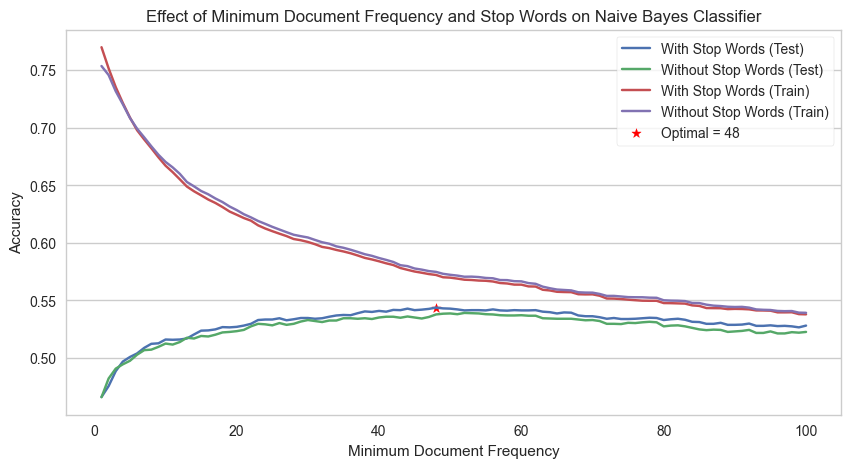

In [76]:
min_dfs = np.linspace(1, 100, 100)
stop_words = ['english', None]

test_accs = np.zeros((len(stop_words), len(min_dfs)))
train_accs = np.zeros((len(stop_words), len(min_dfs)))

for i, stop_word in enumerate(stop_words):
  for j, min_df in enumerate(min_dfs):
    v = CountVectorizer(min_df=int(min_df), stop_words=stop_word)

    x_train_nb, y_train_nb = v.fit_transform(train['text']), np.array(train['label'])
    x_test_nb, y_test_nb = v.transform(val['text']), np.array(val['label'])

    model = BayesianClassifier(alpha=0.20)
    model.fit(x_train_nb, y_train_nb)
    test_accs[i, j] = model.evaluate(y_test_nb, model.predict(x_test_nb))
    train_accs[i, j] = model.evaluate(y_train_nb, model.predict(x_train_nb))


test_opt = np.unravel_index(np.argmax(test_accs), test_accs.shape)

plt.figure(figsize=(10, 5))
plt.plot(min_dfs, test_accs[0], label="With Stop Words (Test)")
plt.plot(min_dfs, test_accs[1], label="Without Stop Words (Test)")
plt.plot(min_dfs, train_accs[0], label="With Stop Words (Train)")
plt.plot(min_dfs, train_accs[1], label="Without Stop Words (Train)")
plt.scatter(min_dfs[test_opt[1]], test_accs[test_opt], color='red', marker='*', label=f"Optimal = {int(min_dfs[test_opt[1]])}")
plt.xlabel("Minimum Document Frequency")
plt.ylabel("Accuracy")
plt.title("Effect of Minimum Document Frequency and Stop Words on Naive Bayes Classifier")
plt.legend(frameon=True)
plt.grid(axis='x')

plt.savefig("4.2.png", dpi=600, bbox_inches='tight')

In [78]:
c = CountVectorizer(min_df=48, stop_words='english')
x_train_nb, y_train_nb = c.fit_transform(train['text']), np.array(train['label'])
x_test_nb, y_test_nb = c.transform(test['text']), np.array(test['label'])
x_val_nb, y_val_nb = c.transform(val['text']), np.array(val['label'])

model = BayesianClassifier(alpha=0.20)
model.fit(x_train_nb, y_train_nb)

y_train_pred = model.predict(x_train_nb)
y_test_pred = model.predict(x_test_nb)
y_val_pred = model.predict(x_val_nb)

print(model.evaluate(y_train_nb, y_train_pred))
print(model.evaluate(y_test_nb, y_test_pred))
print(model.evaluate(y_val_nb, y_val_pred))

0.5721328632808197
0.5211328976034858
0.5437554969217239


We note the general trend that increasing the minimum document frequency correspondingly decreases the training accuracy. However, we note that up to about a document frequency of 48, the test performance actually increases, reaching an optimal of 54.4%. We also note that utilizing stopwords to filter out common language leads to a slight increase in accuracy.

### 4.3 Comparing LLMs

Let us define a base wrapper class (similar to our BERT Wrapper) that we can re-use to evaluate different LLMs.

In [ ]:
class LLMWrapper:
  def __init__(self, model: str, epochs: int = 3, alpha: float = 5e-5, b: int = 32):
    self.model_name = model
    self.model = AutoModelForSequenceClassification.from_pretrained(
      model,
      num_labels=NUM_CLASSES,
    )
    self.device = device
    self.epochs = epochs
    self.alpha = alpha
    self.b = b

  def fit(self, dataset):
    self.model.train()
    self.model.to(self.device)

    training_args = TrainingArguments(
      output_dir="results",
      num_train_epochs=self.epochs,
      per_device_train_batch_size=self.b,
      per_device_eval_batch_size=self.b,
    )

    trainer = Trainer(
      model=self.model,
      args=training_args,
      train_dataset=dataset,
    )

    self.model.to('cpu')
    torch.mps.empty_cache()
    return trainer.train()

  def get_loader(self, dataset):
    dataset = dataset.remove_columns(['text']).rename_column('label', 'labels')
    dataset.set_format('torch')
    return DataLoader(dataset, batch_size=16)

  def predict(self, dataset):
    self.model.to(self.device)
    loader = self.get_loader(dataset)
    self.model.eval()
    yh = []

    with torch.no_grad():
      for batch in tqdm(loader):
        inputs = {k: v.to(self.device) for k, v in batch.items()}
        outputs = self.model(**inputs)
        yh.append(outputs.logits.cpu().numpy())

    self.model.to('cpu')
    torch.mps.empty_cache()
    return np.concatenate(yh)

  def evaluate(self, y, yh):
    metric = evaluate.load('accuracy')
    pred = np.argmax(yh, axis=1)
    return metric.compute(predictions=pred, references=y)

  def evaluate_f1(self, y, yh):
    metric = evaluate.load('f1')
    pred = np.argmax(yh, axis=1)
    return metric.compute(predictions=pred, references=y, average='macro')

  def evaluate_by_class(self, y, yh):
    y = np.array(y)
    pred = np.argmax(yh, axis=1)
    return np.array([np.mean(pred[y == c] == c) for c in range(NUM_CLASSES)])

  def tokenize(self, dataset, add_padding_token: bool = False):
    tokenizer = AutoTokenizer.from_pretrained(self.model_name)

    if add_padding_token:
      tokenizer.padding_side = 'right'
      tokenizer.pad_token = tokenizer.eos_token
      self.model.config.pad_token_id = self.model.config.eos_token_id

    tokenize = lambda x: tokenizer(x['text'], truncation=True, padding='max_length', max_length=128)
    tokenized_ds = dataset.map(tokenize, batched=True)

    return tokenized_ds['train'], tokenized_ds['test'], tokenized_ds['validation']

Let us first examine the performance of the RoBERTa model.

In [ ]:
model = LLMWrapper("FacebookAI/roberta-base", epochs=10, b=8)
tokenized_train, tokenized_test, tokenized_val = model.tokenize(ds)

outputs = model.predict(tokenized_test)
test_acc = model.evaluate(tokenized_test['label'], outputs)
test_f1 = model.evaluate_f1(tokenized_test['label'], outputs)
test_class_accs = model.evaluate_by_class(tokenized_test['label'], outputs)

print(f"Test accuracy: {test_acc['accuracy']:.2%}")
print(f"Test F1: {test_f1['f1']:.4}")
print(test_class_accs)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/287 [00:00<?, ?it/s]

Test accuracy: 4.05%
Test F1: 0.002782
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [34]:
small_train = tokenized_train.shuffle().select(range(2000))

model.fit(small_train)
outputs = model.predict(tokenized_test)
test_acc = model.evaluate(tokenized_test['label'], outputs)
test_f1 = model.evaluate_f1(tokenized_test['label'], outputs)
test_class_accs = model.evaluate_by_class(tokenized_test['label'], outputs)

print(f"Test accuracy: {test_acc['accuracy']:.2%}")
print(f"Test F1: {test_f1['f1']:.4}")
print(test_class_accs)

  0%|          | 0/2500 [00:00<?, ?it/s]

{'loss': 2.1369, 'grad_norm': 10.759106636047363, 'learning_rate': 4e-05, 'epoch': 2.0}
{'loss': 1.2992, 'grad_norm': 23.622684478759766, 'learning_rate': 3e-05, 'epoch': 4.0}
{'loss': 0.6953, 'grad_norm': 33.66801452636719, 'learning_rate': 2e-05, 'epoch': 6.0}
{'loss': 0.3135, 'grad_norm': 10.105875015258789, 'learning_rate': 1e-05, 'epoch': 8.0}
{'loss': 0.16, 'grad_norm': 12.707566261291504, 'learning_rate': 0.0, 'epoch': 10.0}
{'train_runtime': 2302.8643, 'train_samples_per_second': 8.685, 'train_steps_per_second': 1.086, 'train_loss': 0.920985464477539, 'epoch': 10.0}


  0%|          | 0/287 [00:00<?, ?it/s]

Test accuracy: 52.29%
Test F1: 0.3912
[0.65229885 0.85483871 0.35877863 0.35051546 0.38559322 0.34883721
 0.32989691 0.47727273 0.42857143 0.17045455 0.38461538 0.46052632
 0.04347826 0.49122807 0.64615385 0.91153846 0.         0.50537634
 0.8625     0.         0.5046729  0.         0.15730337 0.
 0.63636364 0.48039216 0.45977011 0.51992528]


As expected, the initial performance prior to fine-tuning is very low. We note that the test accuracy after fine-tuning is a bit lower than the performance of the original BERT model. However, as we see from the class accuracies, this is likely due to the training split which may not include instances of certain classes.

Now, let us investigate the DistilGPT2 model. This model is interesting as it is a generative model!

In [35]:
model = LLMWrapper("distilbert/distilgpt2", epochs=10, b=8)
tokenized_train, tokenized_test, tokenized_val = model.tokenize(ds, add_padding_token=True)

outputs = model.predict(tokenized_test)
test_acc = model.evaluate(tokenized_test['label'], outputs)
test_f1 = model.evaluate_f1(tokenized_test['label'], outputs)
test_class_accs = model.evaluate_by_class(tokenized_test['label'], outputs)

print(f"Test accuracy: {test_acc['accuracy']:.2%}")
print(f"Test F1: {test_f1['f1']:.4}")
print(test_class_accs)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilbert/distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/4590 [00:00<?, ? examples/s]

  0%|          | 0/287 [00:00<?, ?it/s]

Test accuracy: 0.22%
Test F1: 0.001674
[0.         0.         0.         0.         0.         0.
 0.04123711 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.85714286 0.         0.
 0.         0.         0.         0.        ]


In [36]:
small_train = tokenized_train.shuffle().select(range(2000))

model.fit(small_train)
outputs = model.predict(tokenized_test)
test_acc = model.evaluate(tokenized_test['label'], outputs)
test_f1 = model.evaluate_f1(tokenized_test['label'], outputs)
test_class_accs = model.evaluate_by_class(tokenized_test['label'], outputs)

print(f"Test accuracy: {test_acc['accuracy']:.2%}")
print(f"Test F1: {test_f1['f1']:.4}")
print(test_class_accs)

  0%|          | 0/2500 [00:00<?, ?it/s]

{'loss': 2.2667, 'grad_norm': 15.999902725219727, 'learning_rate': 4e-05, 'epoch': 2.0}
{'loss': 1.194, 'grad_norm': 24.454683303833008, 'learning_rate': 3e-05, 'epoch': 4.0}
{'loss': 0.5689, 'grad_norm': 30.356462478637695, 'learning_rate': 2e-05, 'epoch': 6.0}
{'loss': 0.2766, 'grad_norm': 3.4759361743927, 'learning_rate': 1e-05, 'epoch': 8.0}
{'loss': 0.1635, 'grad_norm': 13.913487434387207, 'learning_rate': 0.0, 'epoch': 10.0}
{'train_runtime': 1250.2151, 'train_samples_per_second': 15.997, 'train_steps_per_second': 2.0, 'train_loss': 0.8939352294921875, 'epoch': 10.0}


  0%|          | 0/287 [00:00<?, ?it/s]

Test accuracy: 53.79%
Test F1: 0.3541
[0.64942529 0.7311828  0.35114504 0.21134021 0.28813559 0.19767442
 0.24742268 0.43181818 0.19642857 0.13636364 0.17435897 0.32894737
 0.         0.35087719 0.53846154 0.89615385 0.         0.53763441
 0.85       0.         0.47663551 0.         0.06741573 0.
 0.56818182 0.3627451  0.33333333 0.70423412]


Again, we see almost identical results as last time. This indicates that it may not be the model that is the greatest limitation, but rather the features of the dataset itself, i.e., its severely imbalanced nature!

In [85]:
(np.array(train.map(lambda x: {'len': len(x['text'])})['len']) <= 128).sum() / len(train)

Map:   0%|          | 0/36308 [00:00<?, ? examples/s]

np.float64(0.9420513385479784)